In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['font.family'] = 'NanumGothic'
import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans,DBSCAN
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA

In [3]:
df = pd.read_excel('./수입검사결과.xlsx',engine='openpyxl')

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
df.head(3)

,수입신고번호,란번호,신고세관부호,신고과코드,검사일자,수입검사결과코드,신고품명,거래품명,조치내용
0,1393518400666M,4,20,12,20180201,C1,DECORATION CRAFTS,DECORATION CRAFTS,"수량, 중량부족(과세가격 감소)"
1,4352118000216M,2,20,12,20180202,N3,PARTS OF WORKING TOOLS,POST DRIVER PARTS,원산지·적출국 오류정정
2,1235618113568M,1,40,58,20180202,N5,WHEEL,WHEEL,기타 신고항목 오류정정


In [5]:
len(df)

790651

In [6]:
ddf = df[df['수입검사결과코드'].isin (['T6','D6','E4'])].copy()

In [7]:
ddf['조치내용'] = ddf['조치내용'].fillna('')
ddf['total_text'] = ddf['조치내용']
ddf['total_text'] = ddf['total_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","", regex=True)
ddf['total_text'] = ddf['total_text'].str.replace("ㅇ","", regex=True)

In [8]:
# 결측행 삭제
ddf.dropna(axis=0)

,수입신고번호,란번호,신고세관부호,신고과코드,검사일자,수입검사결과코드,신고품명,거래품명,조치내용,total_text
45,1364018233720M,1,40,58,20180514,E4,NATURAL HONEY,MANUKA HONEY 1KG,기타 국민보건 등 침해물품 수입(통관보류),기타 국민보건 등 침해물품 수입통관보류
221,4315018900510M,1,30,81,20180411,D6,PARTS OF MECHANICAL APPLIANCES FOR PROJECTING,"SPRINKLER HEAD WITH COVER,VIKING",기타 원산지 관련사항 위반,기타 원산지 관련사항 위반
365,1334118C62295M,1,40,94,20190110,E4,OTHER,CENTRUM SILVER,기타 국민보건 등 침해물품 수입(통관보류),기타 국민보건 등 침해물품 수입통관보류
519,4395919101120M,1,40,94,20190108,D6,OTHER,BO E8 EARPHONE,동일세번내 고세율로 변경(FTA관련),동일세번내 고세율로 변경FTA관련
539,4344618700621M,1,39,10,20180320,E4,"RED PEPPER SEED, POWDER",CHILLI SEED POWDER,기타 국민보건 등 침해물품 수입(통관보류),기타 국민보건 등 침해물품 수입통관보류
...,...,...,...,...,...,...,...,...,...,...
790407,4237423034788M,1,16,26,20230609,T6,OTHER,TATTOO MACHINETATTOO KITS,기타 국민건강·사회안전 등 침해물품 수입(통관보류),기타 국민건강사회안전 등 침해물품 수입통관보류
790410,4237423852051M,1,16,26,20230609,T6,PIERCING TOOLTATTOO NEEDLES,PIERCING TOOLTATTOO NEEDLES,기타 국민건강·사회안전 등 침해물품 수입(통관보류),기타 국민건강사회안전 등 침해물품 수입통관보류
790412,4237423764645M,1,16,26,20230609,T6,TATTOO TOOLTATTOO NEEDLES,TATTOO TOOLTATTOO NEEDLES,기타 국민건강·사회안전 등 침해물품 수입(통관보류),기타 국민건강사회안전 등 침해물품 수입통관보류
790512,4495923060007M,1,40,C1,20230602,D6,MOULDS,OTHER MOULDS,기타 원산지 관련사항 위반,기타 원산지 관련사항 위반


In [9]:
# 폰트 설치 여부 및 경로 확인
# import matplotlib.font_manager as fm
# sys_font = fm.findSystemFonts()
# [f for f in sys_font if 'Nanum' in f]

In [10]:
def wordcloud(grp, model):
    g1 = ddf[ddf[model] == grp].groupby('total_text')['total_text'].count().reset_index(name='cnt')
    
    # 결과를 딕셔너리로 변환
    g1_ditc = {}
    for idx, row in enumerate(g1.iterrows()):
        g1_ditc[row[1]['total_text']] = row[1]['cnt']

    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # 한글 글씨체 설정
        background_color='white', # 배경색은 흰색으로 
        colormap='Reds', # 글씨색은 빨간색으로
        mask=None, # 워드클라우드 모양 설정
        width=800, height=800 # 이미지 크기 설정
    ).generate_from_frequencies(g1_ditc)
    
    # 사이즈 설정 및 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # 차트로 나오지 않게
    plt.title(str(grp) +'번 그룹 WordCloud')
    plt.savefig(str(model)+ '_' + str(grp) +'.png', facecolor='#eeeeee')
    plt.show()

    print('---' * 30)

In [11]:
okt = Okt() # 형태소 분석기 객체 생성
noun_list = []
for content in tqdm.tqdm(ddf['total_text'].fillna('')): 
    nouns = okt.nouns(content) # 명사만 추출하기, 결과값은 명사 리스트
    noun_list.append(nouns)

100%|██████████| 19561/19561 [00:37<00:00, 527.59it/s]


In [12]:
ddf['nouns'] = noun_list

In [13]:
# Word2Vec 학습
model = Word2Vec(sentences = noun_list, vector_size = 100, window = 5, min_count = 1, workers = 4, sg = 0)

In [14]:
# ddf['nouns']의 값을 하나씩 꺼내서 word2vec 벡터화하고 문장의 단어 벡터를 평균내서 결과를 반환
vectors = ddf['nouns'].apply(lambda x: np.array(np.mean([model.wv[w] for w in x if w in model.wv], axis=0)))

ddf['pad_vectors'] = vectors

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [15]:
# NaN 값을 제거합니다.
ddf = ddf.dropna(subset=['pad_vectors'])

In [16]:
# 비원진 값을 0으로 대입하여 최대크기(100차원) 벡터길이로 모든 자료를 맞춥니다.
max_len = max([len(v) for v in ddf['pad_vectors'] if isinstance(v, np.ndarray)])
pad_vectors = [np.pad(v, (0, max_len - len(v)), 'constant') for v in ddf['pad_vectors'] if isinstance(v, np.ndarray)]
ddf['pad_vectors'] = pad_vectors

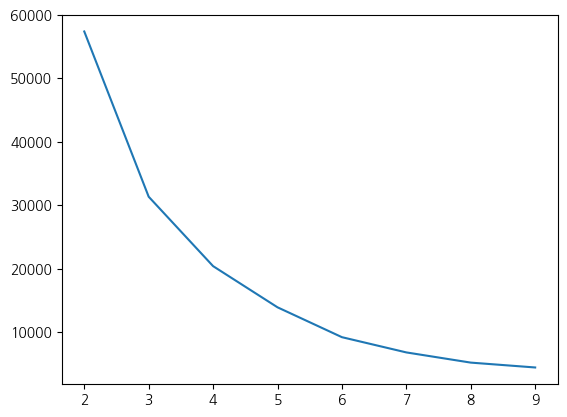

In [17]:
# 군집수 시뮬레이션
itr = []
for i in range(2,10):
    km = KMeans(n_clusters=i, random_state=42, n_init=10)
    km.fit(pad_vectors)
    itr.append(km.inertia_)
    
plt.plot(range(2,10), itr)
plt.show()

In [18]:
# 2차원 배열 형태로 변환합니다.
X = np.array(pad_vectors)
# KMeans 알고리즘을 적용합니다.
kmeans = KMeans(n_clusters=4, random_state=42, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(X)

# 군집 결과를 확인합니다.
labels = kmeans.labels_
ddf['kmeans'] = labels

In [19]:
ddf['kmeans'].value_counts()

0    13342
3     2503
2     2426
1     1281
Name: kmeans, dtype: int64

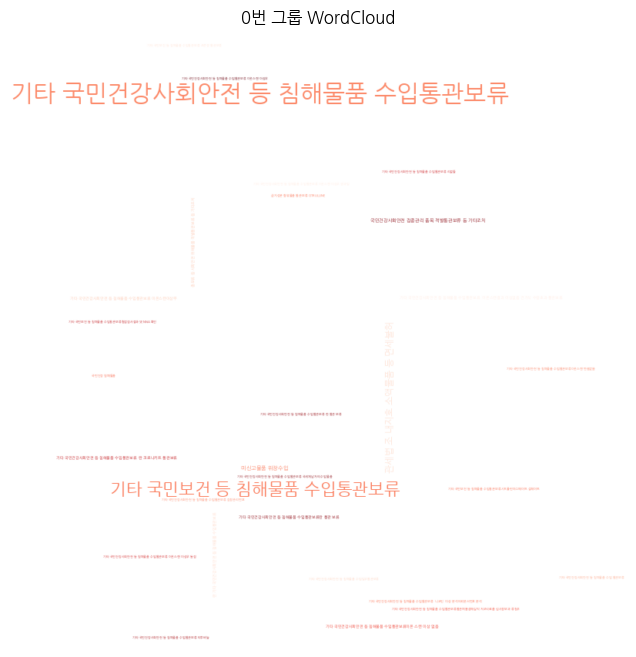

------------------------------------------------------------------------------------------


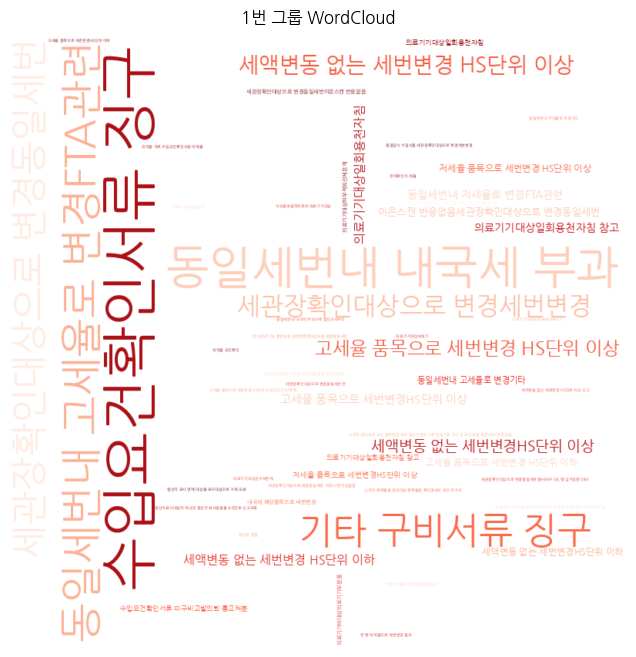

------------------------------------------------------------------------------------------


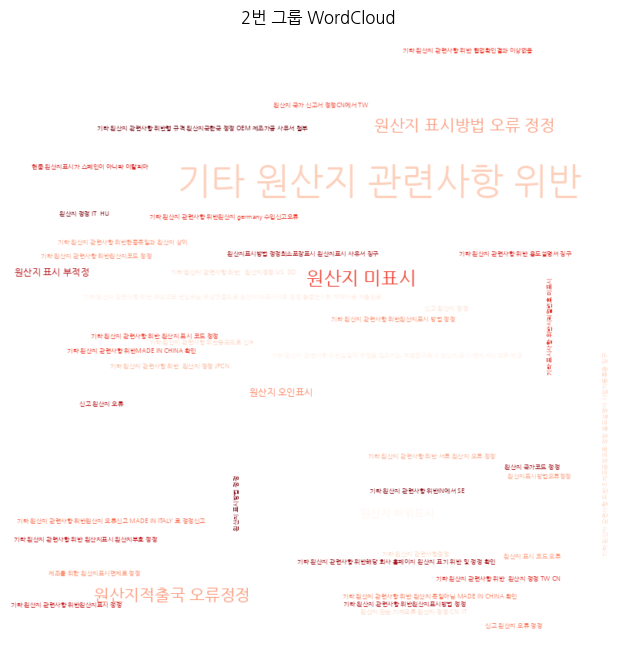

------------------------------------------------------------------------------------------


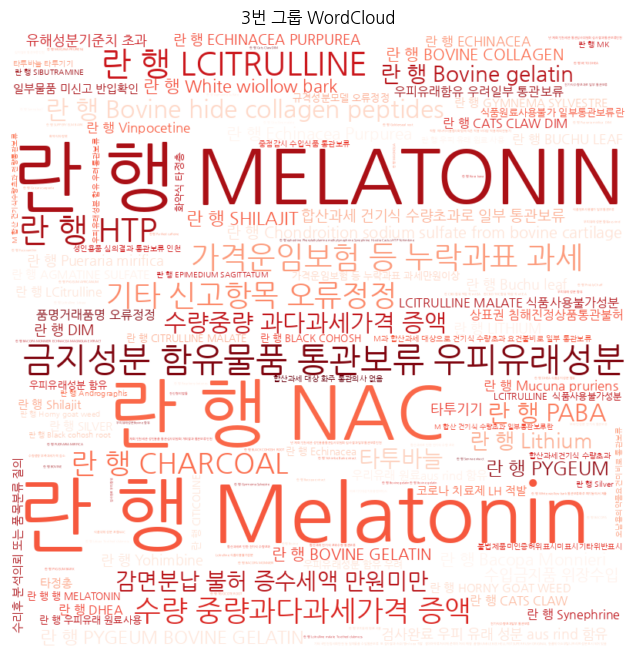

------------------------------------------------------------------------------------------


In [36]:
# 그룹별 워드클라우드 시각화
for i in range(ddf['kmeans'].max()+1):
    wordcloud(i,'kmeans')

In [30]:
# DBSCAN : 인접한 데이터를 클러스터링

X = np.array(pad_vectors) # Normalizer를 이용해 변환된 벡터
# eps 그룹핑할 최대 반경거리
# min_samples 그룹핑한 반경안의 최소 샘플 갯수
model = DBSCAN(eps=0.9,min_samples=250)

# 거리 계산 식으로는 Cosine distance를 이용
model.fit(X)
result = model.fit_predict(X)

In [31]:
ddf['dbscan'] = result

In [32]:
np.unique(ddf['dbscan'])

array([-1,  0,  1,  2,  3,  4])

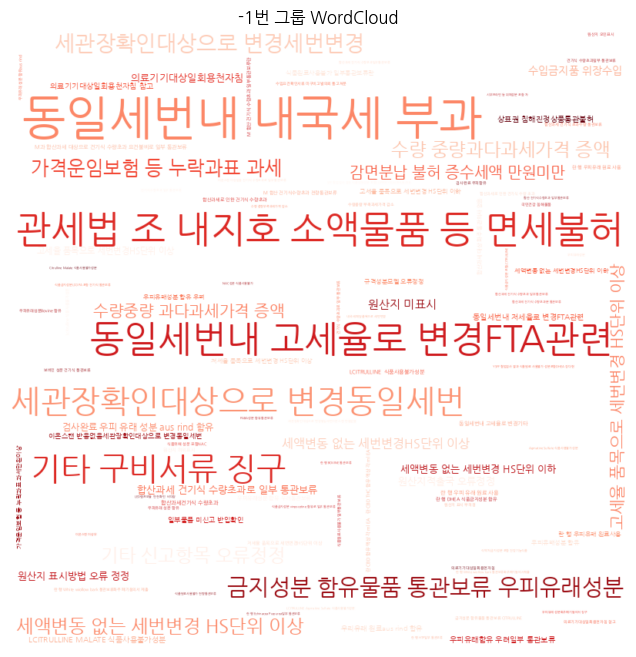

------------------------------------------------------------------------------------------


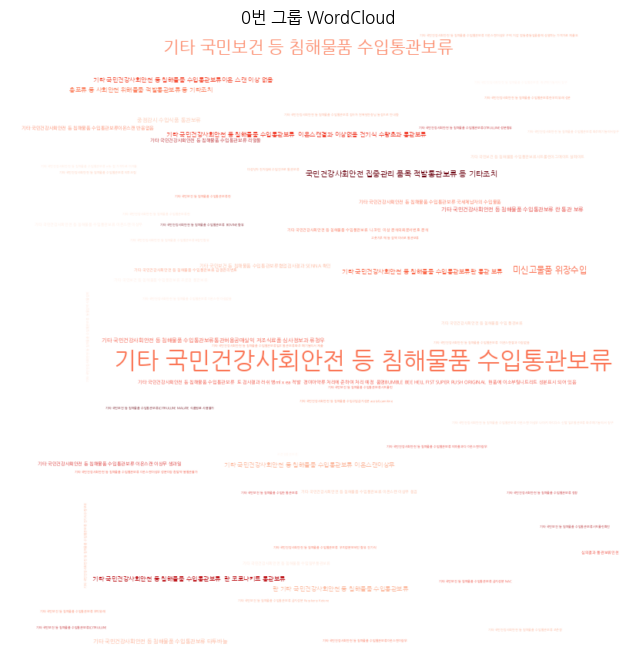

------------------------------------------------------------------------------------------


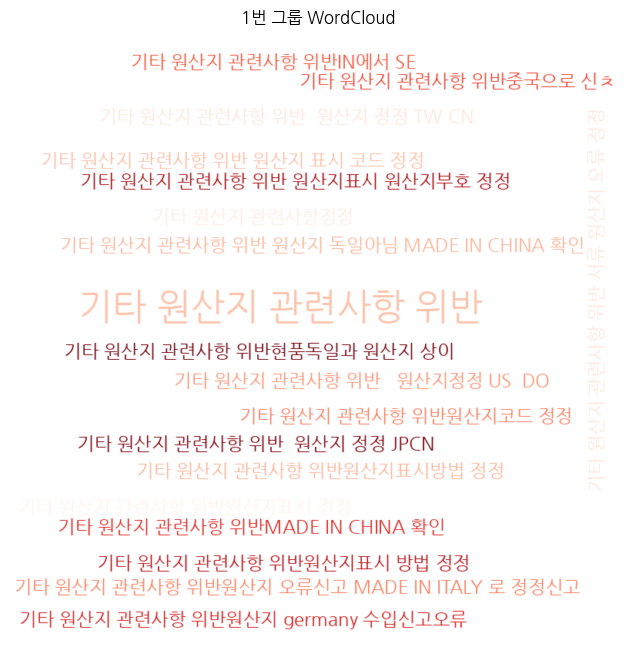

------------------------------------------------------------------------------------------


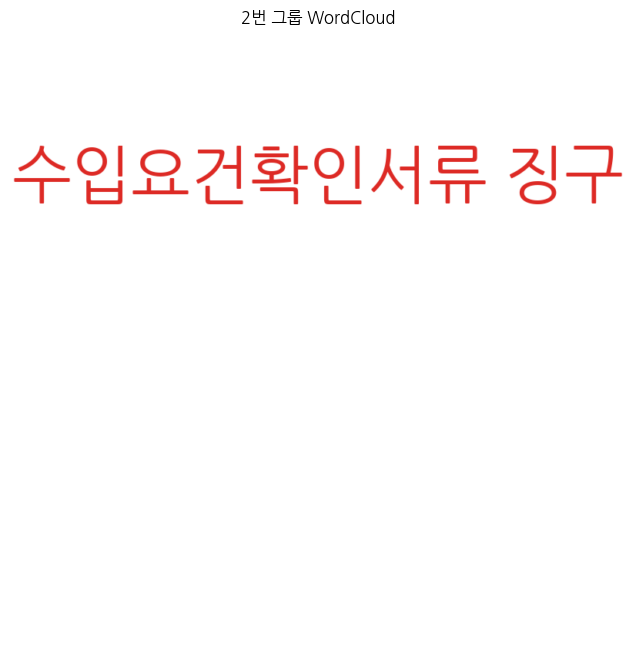

------------------------------------------------------------------------------------------


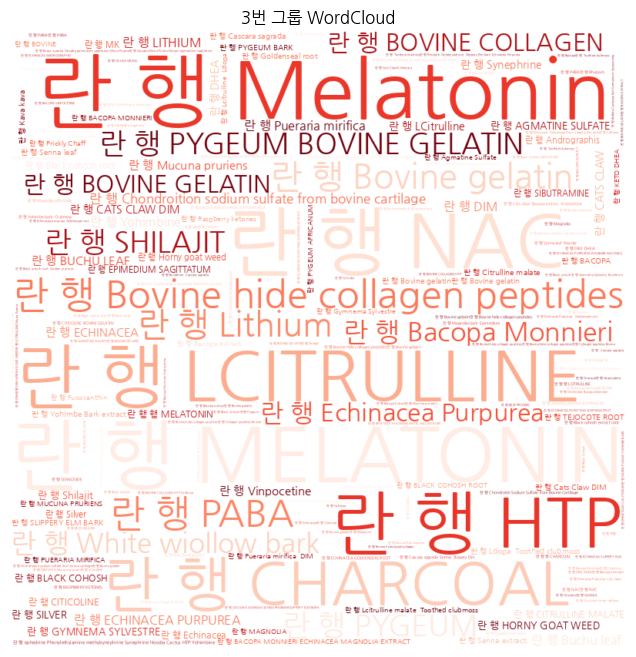

------------------------------------------------------------------------------------------


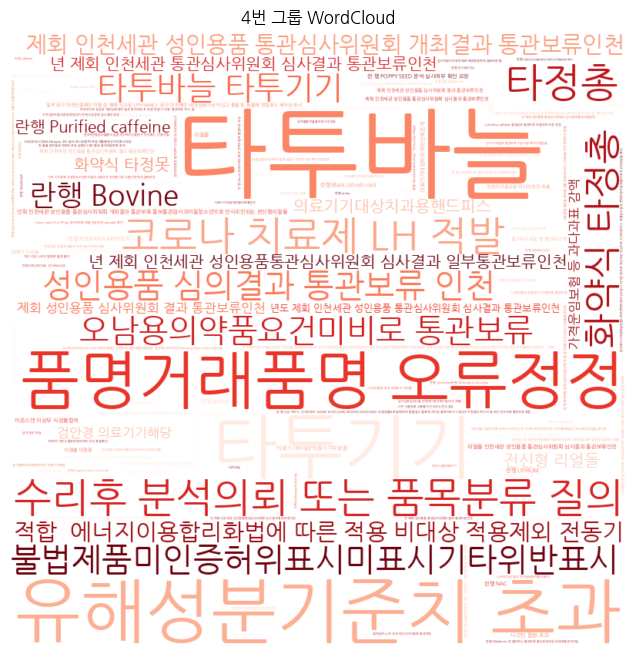

------------------------------------------------------------------------------------------


In [35]:
# 그룹별 워드클라우드 시각화
for i in range(-1, ddf['dbscan'].max()+1):
    wordcloud(i,'dbscan')

In [34]:
ddf.to_excel('./수입검사결과_비지도결과.xlsx',index=False,engine='openpyxl')